In [19]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import columnas_utils as col


import os
import sys
sys.path.append('D:\Apps\github\apuntes_ingenieria_estructural')
from lib import etabs_utils as etb
from lib import sismo_utils as sis


# %load_ext autoreload
# %autoreload 2
%matplotlib inline
%matplotlib notebook

ImportError: cannot import name 'etabs_utils' from 'lib' (unknown location)

## Diseño de Columnas según ACI 318-19

In [ ]:
%cd D:\Apps\github\apuntes_ingenieria_estructural

D:\Apps\github\apuntes_ingenieria_estructural


In [ ]:
# Definicion de las unidades
N = 1
m = 1
cm = 1/100
Pa = 1
MPa = 10**6
pulg = 2.54 / 100

# Definicion de varillas de acero:
d_3 = 3/8 * pulg
d_4 = 1/2 * pulg
d_5 = 5/8 * pulg
d_6 = 3/4 * pulg
d_8 = 1 * pulg

A_3 = d_3 ** 2 /4 * math.pi
A_4 = d_4 ** 2 /4 * math.pi
A_5 = d_5 ** 2 /4 * math.pi
A_6 = d_6 ** 2 /4 * math.pi
A_8 = d_8 ** 2 /4 * math.pi

## Datos de la sección

In [ ]:
#Dimensiones de la columna
b = 35*cm
h = 75*cm
r = 4*cm
column = col.Column(b, h, r)

## Materiales

In [ ]:
# Concreto
fc = 21*MPa #Resistencia a la compresion
eps_u = 0.003 #Deformación unitaria ultima
column.set_concrete(fc, eps_u)

#Acero de refuerzo
fy = 420*MPa #Esfuerzo a la fluencia del acero
Es = 200000*MPa #Módulo de elasticidad del acero
eps_y = fy/Es #Deformación de fluencia del acero
column.set_steel_reb(fy, Es)

## Acero de Refuerzo Colocado

In [ ]:
d_p = d_5 #diámetro principal
d_s = d_5 #diámetro secundario
d_st = d_3 #diámetro del estribo
n_f = 6  #filas de acero
n_c = 3 #columnas de acero
column.set_rebar(d_p, d_s, d_st, n_f, n_c)

## Resistencia a la compresión pura de la Columna

In [ ]:
#factor de minoración
phi = 0.65
column.compress_resist(phi)
print('Resistencia a la compresión pura reducida: {:.2f} N'.format(column.phiP_n))

## Diseño a Flexocompresión

In [ ]:
#Importación de cargas
cargas = pd.read_csv('cargas.csv',sep=';')

#Conversion de unidades
cargas.P = cargas.P*9.81*10**3
cargas.M2 = cargas.M2*9.81*10**3
cargas.M3 = cargas.M3*9.81*10**3

In [ ]:
cargas

In [ ]:
#Diagrama de flexocompresión:
column.biaxial_flex_comp()

In [ ]:
#Datos generados:
column.biaxial_f_c

In [ ]:
#Diagrama a flexocompresión
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
column.plot_bi_f_c(ax,loads=cargas)
plt.title('Diagrama de Flexocompresión')
ax.set_xlabel("$\phi Mn_x$ (kN-m)")
ax.set_ylabel("$\phi Mn_x$ (kN-m)")
ax.set_zlabel("$\phi Pn$ (kN)")
plt.show()

In [ ]:
fig, ax = plt.subplots()
column.plot_f_c(ax,loads=cargas,axis='x')
plt.show()

In [ ]:
fig, ax = plt.subplots()
column.plot_f_c(ax,loads=cargas,axis='y')
plt.show()

## Comprobación Viga débil Columna Fuerte

La resistencia a la flexión de las columnas debe ser por lo menos 6/5 de la resistencia a la flexion de la viga que se apoya en ella:

$ \hspace{5.5cm} \Sigma M_{nc} \geq (6/5) \Sigma M_{nb} $

In [ ]:
#Datos de la viga
viga_1 = col.Beam(b=25*cm,h=40*cm,r=9*cm)
viga_1.set_rebar(d_s=d_5, n_s=4)

#Momento Resistente máximo con acero en tracción solamente
As = viga_1.Ast
fy = viga_1.fy
fc = viga_1.fc
b = viga_1.b
d = viga_1.d
phi_f = 0.9
viga_1.a = As*fy/(0.5*fc*b)
viga_1.Mn = As*fy*(d-viga_1.a/2)
viga_1.phi_Mn = phi_f*viga_1.Mn

In [ ]:
#Elegimos la menor carga que no se encuentra en el último nivel
P_min = cargas[cargas.Piso!=6]['P'].max()*-1

#Filtro de datos para la menor carga
data = column.biaxial_f_c
data = data[data.theta==0]
data = data[abs(data.Pn-P_min)== min(abs(data.Pn-P_min))]

#Momento de diseño
Mnx_des = float(data.Mn_x)

#Verificación:
if 2*Mnx_des > 1.2*(2*viga_1.Mn):
    print('OK')
else:
    print('Viga más fuerte que la columna')

## Desarrollo del acero en la columna
A lo largo de la altura libre de la columna, el refuerzo longitudinal debe seleccionarse de manera que:

$\hspace{5cm} 1.25\cdot l_d = l_u/2 $
- $l_u$ luz libre de la columna
- $l_d $ longitud de desarrollo del acero

In [ ]:
#Cálculo de la longitud de desarrollo sin considerar confinamiento de estribos
lu = 1.95*m
lamb = 1
psi_g = 1
psi_e = 1
psi_s1 = 1
psi_s2 = 0.8
psi_ts = 1.3
psi_ti = 1
db = 0.75 * pulg

psi_ts_e = psi_ts*psi_e 
if psi_ts_e > 1.7:
    psi_ts_e = 1.7
    
sqrt_fc = (fc/10**6)**0.5*MPa
if sqrt_fc > 8.3*MPa:
   sqrt_fc = 8.3*MPa

ld3 = fy/(1.1*lamb*sqrt_fc)*psi_g*psi_e*psi_s2*psi_g*db
ld3

In [ ]:
#Considerando el efecto de los estribos:
r = column.r
d_st = column.d_st
nb = column.n_c

cb1 = r+d_st+db*0.5
cb2 = (b-2*r-2*d_st-db)/(nb-1)/2
cb = min(cb1,cb2)

k_tr = 0

#restricciones de la norma
alpha = (cb+k_tr)/db
if alpha > 2.5:
    alpha = 2.5

#Por tanto:
ld3 = ld3/alpha 
ld3

In [ ]:
#Verificación
if 1.25*ld3 <= lu/2:
    print('Ok')
else:
    print('El acero no puede desarrolarse en la columna')

## Diseño de estribos

### Longitud de confinamiento:
Es la longitud $l_o$ medida desde cada cara del nudo a ambos lados de cualquier sección donde pueda ocurrir fluencia por flexión como resultado de desplazamientos laterales que exceden el rango elástico de comportamiento.

In [ ]:
hm= 2.1*m
h = column.h
Lo = max(b,h,hm/6,45*cm)
Lo

### Distribución de los estribos en la sección
La cantidad de refuerzo transversal debe cumplir con le exigido en la tabla 18.7.5.4:
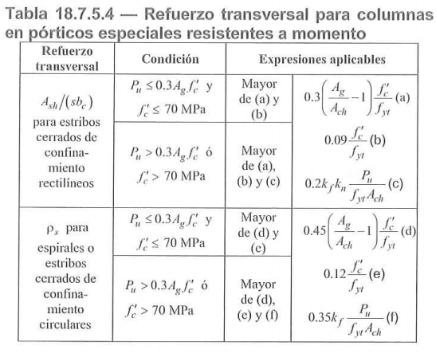

- $k_f$: factor de resistencia del concreto $k_f=\frac{f'_c}{175}+0.6 \geq 1.0$
- $k_n$: factor de efectividad del confinamiento $k_n=\frac{n_l}{nl-2}$
- $n_l$: número de barras longitudinales alrededor del perímetro del núcleo de una columna con estribos cerrados de confinamiento que están soportados lateralmente por una esquina del estribo cerrado de confinamiento con ganchos sísmicos

In [ ]:
s = 10*cm #Separación inicial de estribos
bc = b-2*r
hc = h-2*r
Ach = bc*hc
P_max = cargas.P.min()
Ag = column.Ag

#Dirección X:
Ash1 = 0.09*s*bc*fc/fy
Ash2 = 0.3*s*bc*(Ag/Ach-1)*fc/fy
Ash3 = 0
nl = 10
if 0.3*fc*Ag < P_max:
    kf = fc/175+0.6
    if kf < 1.0:
        kf = 1.0 
    kn = nl/(nl-2)
    Ash3 = 0.2*kf*kn*P_max/(fy*Ach)
Ashx = max(Ash1,Ash2,Ash3)
Ashx*10**4

In [ ]:
#Revisión Y
Ash1 = 0.09*s*hc*fc/fy
Ash2 = 0.3*s*hc*(Ag/Ach-1)*fc/fy
Ash3 = 0
nl = 10
if 0.3*fc*Ag < P_max:
    kf = fc/175+0.6
    if kf < 1.0:
        kf = 1.0 
    kn = nl/(nl-2)
    Ash3 = 0.2*kf*kn*P_max/(fy*Ach)
Ashy = max(Ash1,Ash2,Ash3)
Ashy*10**4

In [ ]:
#Comprobracion:
Ashpx = 2*A_4 #dos ramas de acero #4
Ashpy = 4*A_3+2*A_4 #dos ramas de acero #4 y cuatro ramas de #3

if Ashpx < Ashx:
    print('Acero insuficiente en X')
else:
    print('Acero colocado en el sentido X: {:.2f} cm^2'.format(Ashpx*10**4))
if Ashpy < Ashy:
    print('Acero insuficiente en Y')
else:
    print('Acero colocado en el sentido Y: {:.2f} cm^2'.format(Ashpy*10**4))

### Cortante que toma el acero considerando rótula en la columna

In [ ]:
#Diagramas a flexocompresión mayorados

#Momentos en X
flex_comp_data = column.nominal_PM(theta=0,mayored=True)
Pn_x_may = flex_comp_data[0]
Mn_x_may = flex_comp_data[2]

#Momentos en Y
flex_comp_data = column.nominal_PM(theta=90,mayored=True)
Pn_y_may = flex_comp_data[0]
Mn_y_may = flex_comp_data[4]

In [ ]:
#Diagrama en el eje x    
fig, ax = plt.subplots()
column.plot_f_c(ax,loads=cargas,axis='x',factored=False)
ax.set_xlabel("$M_x$ (kN-m)")
ax.set_ylabel("$Pn$ (kN)")
plt.show()

In [ ]:
#Diagrama en el eje y  
fig, ax = plt.subplots()
column.plot_f_c(ax,loads=cargas,axis='y',factored=False)
ax.set_xlabel("$M_y$ (kN-m)")
ax.set_ylabel("$Pn$ (kN)")
plt.show()

In [ ]:
#Momentos Probables
P_max = cargas['P'].min()
i = column.find_i(Pn_x_may,P_max)
Mnx_des = Mn_x_may[i]
Pnx_des = Pn_x_may[i]

i = column.find_i(Pn_y_may,P_max)
Mny_des = Mn_y_may[i]
Pny_des = Pn_y_may[i]

In [ ]:
#Cortantes ultimas por capacidad
hn1 = 1.95*m
hn2 = 2.1*m
Vux = 2*Mnx_des/hn2
Vuy = 2*Mny_des/hn1

In [ ]:
#Cortante que toma el concreto:
phi_c =0.75 #factor de reduccion
#Direccion X
Y = abs(P_max)/(6*Ag)
Y = min(Y,0.05*fc)
Vcx1 = (0.17*lamb*(fc/MPa)**0.5*MPa+Y)*h*(b-r-d_st)
Vcx2 = (0.42*lamb*(fc/MPa)**0.5*MPa)*h*(b-r-d_st)
Vcx = min(Vcx1,Vcx2)
Vsx = (Vux-phi_c*Vcx)/phi_c
#Direccion Y
Vcy1 = (0.17*lamb*(fc/MPa)**0.5*MPa+Y)*b*(h-r-d_st)
Vcy2 = (0.42*lamb*(fc/MPa)**0.5*MPa)*b*(h-r-d_st)
Vcy = min(Vcy1,Vcy2)
Vsy = (Vuy-phi_c*Vcy)/phi_c

In [ ]:
#Comprobacion de la sección transversal por cortante
Vumx = phi_c*(Vcx+0.66*(fc/MPa)**0.5*MPa*h*(b-r-d_st))
Vumy = phi_c*(Vcy+0.66*(fc/MPa)**0.5*MPa*b*(h-r-d_st))

if Vumx < Vux:
    print('Aumentar seccion')
else:
    print('OK')
    
if Vumy < Vuy:
    print('Aumentar seccion')
else:
    print('OK')

In [ ]:
#Separación de estribos:
#Direccion X
n = 2
n2 = 0
theta = math.radians(45)
Ast = A_4*n+A_3*n2*math.cos(theta)
sx = Ast*fy*(h-r-d_st)/Vsy
sx*100

In [ ]:
#Direccion Y
n1 = 2
n2 = 4
n3 = 0
theta = math.radians(45)
Ast = A_4*n1+A_3*n2+A_3*n3*math.cos(theta)
sy = Ast*fy*(b-r-d_st)/Vsx
sy*100

In [ ]:
#Separacion minima
d_p = column.d_p
s = min(sx,sy,6*d_p,15*cm)
s

### Cortante que toma el acero considerando rótula en las vigas

In [ ]:
#Viga en el sentido Y:
viga_1.ln = 5.65*m-0.2*m
#Vigas en el sentido X
viga_2 = col.Beam(b=35*cm,h=55*cm,r=9*cm)
viga_2.set_rebar(d_s=[d_5,d_6], n_s=[2,2])
viga_3 = col.Beam(b=35*cm,h=55*cm,r=9*cm)
viga_3.set_rebar(d_s=d_5, n_s=3)

viga_2.ln = 4.56*m-0.35*m
viga_3.ln = 4*m-0.35*m

In [ ]:
#Momentos Probables en las vigas
#Sentido X
viga_1.a = viga_1.Ast*1.25*fy/(0.85*fc*viga_1.b)
Mpx = viga_1.Ast*1.25*fy*(viga_1.d-viga_1.a/2)
Vux = 4*Mpx/(2*hn2)
#Sentido Y
viga_2.a = viga_2.Ast*1.25*fy/(0.85*fc*viga_2.b)
Mpy1 = viga_2.Ast*1.25*fy*(viga_2.d-viga_2.a/2)
viga_3.a = viga_3.Ast*1.25*fy/(0.85*fc*viga_3.b)
Mpy2 = viga_3.Ast*1.25*fy*(viga_3.d-viga_3.a/2)
Mpy = max(Mpy1,Mpy2)
Vuy = 2*Mpy/(2*hn2)

In [ ]:
#Cortantes producidos por las vigas en X
V2 = 2*Mpx/ln2
V1 = 2*Mpx/ln3
#Longitud de diseño de la columna en X
lc1 = 0.5*hn2+viga_1.h
#Cortante de la columna en el sentido X
Vcolx = 2*Mpx/lc1 + (V1+V2)*b/2/lc1
Vcolx

In [ ]:
#Cortantes producidos por la viga en Y
V3 = (Mpy1+Mpy2)/viga_1.ln
#Longitud de diseño de la columna en Y
lc2 = 0.5*hn1+viga_2.h
#Cortante de la columna en el sentido Y
Vcoly = Mpy/lc2+V3*h/2/lc2
Vcoly

## Fuerza cortante en el Nudo:

In [ ]:
#Sentido X (dos vigas llegando al nudo)
T1 = viga_1.Ast*fy
T2 = T1
Vux = T1+T2-Vcolx
Vux

In [ ]:
#Sentido Y (una viga en el nudo)
T3 = viga_2.Ast*fy
Vuy = T3-Vcoly
Vuy

In [ ]:
#En nudos viga columna de porticos a momento especiales usamos un factor de:
phi_c = 0.85
fact = {'IA':1.7,
       'IB':1.3,
       'IC':1.3,
       'ID':1.0,
       'IIA':1.3,
       'IIB':1.0,
       'IIC':1.0,
       'IID':0.7}

#Análisis en X:
tipox = 'I' #columna continua
v_c = 'y' #continuidad de la viga después del nudo
if v_c == 'y':
    if viga_2.b >= 0.75*h:
        tipox += 'A'
    else:
        tipox += 'B'
else:
    if viga_2.b >= 0.75*h:
        tipox += 'C'
    else:
        tipox += 'D'
tipox

In [ ]:
#Análisis en Y:
tipoy = 'I' #columna continua
v_c = 'n' #continuidad de la viga después del nudo
if v_c == 'y':
    if viga_2.b >= 0.75*h:
        tipoy += 'A'
    else:
        tipoy += 'B'
else:
    if viga_2.b >= 0.75*h:
        tipoy += 'C'
    else:
        tipoy += 'D'
tipoy

In [ ]:
#Cortante que resiste el nudo direccion X
befx = min(viga_1.b+b,viga_1.b) #Ancho efectivo del nudo en X
Ajx = befx*b
phiVnx = phi_c*fact[tipox]*(fc/MPa)**0.5*MPa*Ajx
phiVnx

In [ ]:
#Cortante que resiste el nudo direccion X
befy = min(viga_2.b+h,viga_2.b) #Ancho efectivo del nudo en X
Ajy = befy*h
phiVny = phi_c*fact[tipoy]*(fc/MPa)**0.5*MPa*Ajy
phiVny

In [ ]:
#Propuesta al nudo en X
b = 40*cm
bv1 = 35*cm
fc = 28*MPa
befx = min(bv1+b,bv1)
Ajx = b*befx
phiVnx = phi_c*fact[tipox]*(fc/MPa)**0.5*MPa*Ajx
phiVnx